About this script:

This script takes a csv file exported from the Google sheet titled 'Research IT Consulting Engagements Log.' 
('Consulting Log' tab) at:
https://docs.google.com/spreadsheets/d/1BzVbvY0dpUhY3JxSXA6RPaLiLS5IRTRpdZVYrgf9zKI

The script manipulates each row of the spreadsheet as a list. It uses list notation to refer to each column -- or what had been a column in the spreadsheet. For convenience, here are the list indices and headers associated with each column: 

| Index | Column header |
| ------| ------------- |
| [0]   | Start date |
| [1]   | Consultant(s) |
| [2]   | Client(s) |
| [3]   | PI (Whose project is it?) |
| [4]   | Department/ORU |
| [5]   | Research Domain (e.g. Egyptology) |
| [6]   | Position (grad, postdoc, faculty, undergrad, researcher) |
| [7]   | Project type (dissertation, etc.) |
| [8]   | Related course (if applicable) |
| [9]   | Research IT service |
| [10]  | Topic (uncontrolled) |
| [11]  | Category (controlled) |
| [12]  | Source |
| [13]  | Hand-off and/or referral |
| [14]  | Complexity (RDM) |
| [15]  | Status |
| [16]  | Link to details |
| [17]  | Notes|

In [1]:
import csv, sys
import re
from collections import Counter
from datetime import date, datetime


The .csv file is containing the data is now generated from Google sheet ("Research IT Consulting Engagement Log"), 
then filtered for date, RIT Service (= 'RDM') and Category (= consultation-related categories: 'user support' + all categories beginning 'RDM')

These are the parameters (arguments) that must be provided to the script:
1. The filepath that points to the .csv file containing our data (which is now being generated from the "Research IT Consulting Engagements Log.")
2. The filename of the .csv file.
3. The 'report_period_descriptor' will be the text included in the first line of the report created by the script.
4. The 'report_start' is the earliest consultation start date of the period covered by the report.
5. The 'report_end' is the latest consultation start date of the period covered by the report

You can load these from a file if you wish. The file should be a .py file that contains exactly the information shown below in lines 2 through 7. Place the file in the same folder as this Jupyter Notebook file, or provide the path to it in the cell magic command '%load.' (Remove the '#' before '%load' to run the command.)

In [2]:
# %load Metrics_args_POSTDATACLEANUP/RDM_metrics_args-ALL-through-FY2018-Q2.py
# These are the arguments provided to the script
filepath = '/Users/rjaffe/Documents/RDM/RDM_Metrics/MetricsData/RITConsultingEngagementLog_Google-downloads/'
filename = 'Research-IT-Consulting-Engagements-Log_20180206_0141PST_AfterDataCleanup.csv'
report_period_descriptor = 'the period from January 1, 2015 through December 31, 2017'
report_start = '2015-01-01'
report_end = '2017-12-31'


This script utilizes dictionaries to store values for counting and to aggregate ("roll up"") individual values 
under parent values. There are dictionaries for:
1. The consultant involved in the consultation
2. The department or ORU of the researcher/client
3. The position or role of the researcher/client
4. The category (RDM service area or lifecycle stage)
5. The source of the consultation (or 'referral in'), rolled up to the organizational unit of the individual
6. The referral (out), i.e., the person to whom the case was referred, rolled up to their organizational unit
7. The complexity of the case
8. The parent school, college or division of the researcher's/client's department or unit
9. The College of Letters & Science as a whole (includes four divisions).

We also use two other dictionaries to hold text values that vary by column:
1. The labels used in our output for empty values
2. The headings used in our output.

Before we load the data file, let's initialize some configuration for the various dictionaries. The configuation is kept in a file currently named config_20171104.py, which we load using the cell magic command '%load.' (The file can be located in the same folder as the notebook file itself, or a path can be provided.) 

As new values are added to the Google Sheet, they should be added to the second value list within the correct dictionary here.

In [3]:
# %load config_20171104.py
# Positional elements (columns) with the following indices -- and only those elements, at present --
# will be gathered and counted using a dictionary
dictable_cols = [1, 4, 6, 11, 12, 13, 14]

# In this version, we bring the "dictable columns" into dictionaries called:
# • ccounter (consultants) 
# • dcounter (departments/ORUs)
# • pcounter (position)
# • cacounter (category)
# • scounter (source)
# • rcounter (referrals in and out) and 
# • cocounter (complexity).

# Next we do modifications -- rolling up departmental values to their school, college or organizational parent; 
# L&S is first rolled up to its divisions, then aggregated as a college -- and store in new dictionaries: 
# • pacounter for values rolled-up by parent
# • lscounter for Letters & Science divisions rolled up into a single total

#Initialize dictionaries that we'll use later
ccounter, dcounter, pcounter, cacounter, scounter, rcounter, cocounter, \
pacounter, lscounter = {},{},{},{},{},{},{},{},{}

# let the data do the heavy lifting...everything is in this dict!
ref_rollups = {
    'lib': ['The Library', ['Harrison Dekker', 'Jamie Wittenberg', 'Susan Edwards', 'Steve Mendoza', 'Steven Mendoza',
                            'Margaret Phillips', 'data-consult list (Library)', 'Brian Quigley', 'Library', 'Jesse Silva',
                            'Data Storage/Sharing and the Social Sciences Working Group', 'Erik Mitchell', 'Cody Hennesy',
                            'Susan Powell', 'Anna Sackmann', 'David Eiffler', 'Yasmin Alnoamany', 'Stacy Reardon',
                            'Celia Emmelhainz', 'Hilary Schiraldi', 'Rachael Samberg', 'Amy Neeser', 'Josh Quan', 'Mark Hemhauser'
                            'Kortney Rupp']],
    'css': ['Campus Shared Services - IT', ['Brett Larsen', 'Daniel Bass', 'Johnathon Kogelman',
                                            'Johnathon Kogelman (CSS-IT)', 'CSS-IT', 
                                            'Referred by Johnathon Kogelman (CSS-IT)', 'Edgar Ortega (CSS-IT)',
                                            'request to Rick from Daniel Bass',
                                            'email to Rick from Daniel Bass', 'Daniel Bass (CSS-IT)',
                                            'CSS_IT (Jon Valmores)']],
    'dlab': ['D-Lab', ['D-Lab Consulting List', 'D-Lab', 'Jon Stiles', 'Jon Stiles (D-Lab)', 'Zawadi Rucks Ahidiana',
                       'Rick Jaffe (via D-Lab Consulting web page)', 'dlab-consultants@lists.b.e', 'Jack Burris (D-Lab)',
                       'd-lab consultants list', 'referred to D-Lab/Jon Stiles', 'D-Lab consultants list', 'Laura Nelson  (D-Lab)',
                       'Rick at d-lab consulting Ticket #29430', 'D-Lab ticket#29433', 'Chris Hench (D-Lab)', 'Drew Hart (D-Lab)']],
    'scf': ['Statistical Computing Facility', ['Chris Paciorek', 'Ryan Lovett']],
    'brc': ['Berkeley Research Computing',
            ['Patrick Schmitz', 'Aron Roberts', 'Aaron Culich', 'Jason Christopher', 'Kelly Rowland', 'Gary Jung',
             'BRC Cloud Consulting', 'Jason Huff (Computational Genomics Resource Lab)', 'Maurice Manning', 'Oliver Muellerklein',
             'Berkeley Research Computing - Cloud', 'Yong Qin', 'Deb McCaffrey', 'Krishna Muriki', 'email to BRC', 
             'brc@berkeley.edu']],
    'dh': ['Digital Humanities @ Berkeley', ['Quinn Dombrowski', 'Camille Villa', 'Digital Humanities',
                                             'Claudia Natalia Von Vacano']],
    'rdm': ['RDM Consulting', ['researchdata@berkeley.edu', 'Rick Jaffe', 'Chris Hoffman', 'John Lowe',
                               'BRC Survey 2016 (Response to follow-up from Jamie)', 'email to Rick Jaffe', 
                               'Follow-up', 'Rick', 'follow up', 'email to Rick and Jason', 
                               'researchdata@b.e. (after browsing web site)', 'researchdata@b.e.', 
                               'researchdata@b.e', 'email to Rick from Jessica', 'email to Rick from Carla',
                               'email to Rick from Laura', 'email to Rick from Phuong', 'email to Rick from Sarah',
                               'Anna Sackman (RDM)', 'Josh Quan (RDM)', 'Email to Rick']],
    'cdl': ['California Digital Library', ['Joan Starr', 'Stephanie Simms', 
                                           'Daniella Lowenberg (DASH), via Quinn Dombrowski']],
    'ist': ['Information Services & Technology - API', ['Jennifer Bellenger', 'Jon Broshious', 'Ian Crew', 'Jon Hays', 'Jon Hays (bConnected)',
                                                        'bConnected', 'Michael Leefers', 'Alex Walton', 
                                                        'referred by Ian (bConnected)', 
                                                        'referred to Rick by Jennifer Bellenger (bConnected)',
                                                        'Forwarded by Beth Muramoto (GSE) to Ian Crew (bConnected), who forwarded it in turn to researchdata@berkeley.edu',
                                                        'bconnected']],
    'ist': ['Information Services & Technology', ['David Rieger (IST)', 'Erik McCroskey', 'Blaine Isbelle (IST)', 
                                                  'Jonathon Taylor (IST)', 'Joe Silva (IST)']],
    'isp': ['Information Security & Policy', ['Leon Wong', 'Chris Doane']],
    'micronet': ['Micronet', ['micronet', 'Micronet', 'micronet list', 'Micronet list']],
    'iao': ['Industry Alliances Office', ['Nicole Hensley', 'Nicole Hensley (IAO/IPIRA)', 'Nicole Hensley (IAO)',
                                         'email to Chris and Rick from Eric Giegerich',
                                         'email from Nicole Hensley to Rick and Chris',
                                         'Email from Nicole Hensley to Chris and to Rick']],
    'ssw': ['School of Social Welfare', ['David Fullmer']],
    'bids': ['Berkeley Institute for Data Science', ['BIDS']],
    'brdo': ['Berkeley Research Development Office (VCRO)', ['Barbara Ustanko via Chris Hoffman']],
    'lsit': ['Letters & Science IT', ['Michael Quan (Letters & Science IT)']],
    'ais': ['Academic Innovation Studio', ['AIS drop-in (handled by Rick)']],
    'musinf': ['Museum Informatics', ['BIDS Faire CSpace Portals poster']],
    'rit': ['Research IT', ['research-it@berkeley.edu']],
    'cpo': ['Campus Privacy Officer', ['Lisa Ho']],
    'aws': ['Amazon Web Services', ['Matt Jamieson (AWS)', 'Brad Dispensa (AWS)']]
}

org_rollups = {
    'cchem': ['College of Chemistry', ['Department of Chemistry']],
    'ced': ['College of Environmental Design', ['City and Regional Planning', 'Department of City & Regional Planning', 'Landscape Architecture & Environmental Planning']],
    'citris':['Center for Information Technology Research in the Interest of Society', ['Center for Information Technology Research in the Interest of Society (CITRIS)']],
    'cnr': ['College of Natural Resources', ['College of Natural Resources (CNR)', 'Department of Agricultural & Resource Economics (ARE)',
                                             'Department of Environmental Science, Policy & Management (ESPM)',
                                             'Department of Plant and Microbial Biology', 'Master of Development Practice (CNR)']],
    'coe': ['College of Engineering', ['College of Engineering (CoE)','Department of Bioengineering',
                                       'Department of Civil and Environmental Engineering',
                                       'Department of Mechanical Engineering (ME)',
                                       'Department of Nuclear Engineering',
                                       'Division of Electrical Engineering/EECS',
                                       'Institute for Environmental Science and Engineering']],
    'dh':  ['Digital Humanities at Berkeley', ['Digital Humanities at Berkeley', 'Digital Humanities at Berkeley (DH)', 'Digital Humanities @ Berkeley']],
    'eslib':['Ethnic Studies Library', ['Ethnic Studies Library']],
    'gbsmrc':['Golden Bear Sleep & Mood Research Clinic', ['Golden Bear Sleep & Mood Research Clinic']],
    'gse': ['Graduate School of Education', ['Graduate School of Education (GSE)']],
    'gsj': ['Graduate School of Journalism', ['School of Journalism']],
    'haas':['Haas School of Business', ['Haas School of Business']],
    'hwni':['Helen Wills Neuroscience Institute', ['Helen Wills Neuroscience Institute (HWNI)', 'Neuroscience (HWNI)']],
    'inf': ['School of Information', ['School of Information']],
    'intl':['International programs', ['International Computer Science Institute (ICSI)']],
    'ist': ['Information Services & Technology', ['Information Services & Technology (IST)']],
    'law': ['Berkeley Law', ['School of Law', 'Boalt Hall School of Law', 'Jurisprudence and Social Policy', 'Legal Studies Program']],
    'lbl': ['Lawrence Berkeley Lab', ['Lawrence Berkeley Lab (LBL)']],
    'lib': ['Library', ['Bancroft Library', 'Bancroft Library - Oral History Center', 'C.V. Starr East Asian Library', 'Ethnic Studies Library', 
                        'Library', 'ITS Library']],
    'ls':  ['College of Letters & Science - College-wide', ['College of Letters and Science (L&S)', 'D-Lab', 'Undergraduate Interdisciplinary Studies',
                                                            'L&S / California Alliance (multi-University, UCB coordinating)']],
    'lsa': ['College of Letters & Science - Arts & Humanities', ['Department of English', 'Department of History of Art', 'Department of Music', 
                                                                 'Department of Near Eastern Studies', 'Department of Rhetoric', 
                                                                 'Department of Slavic Languages and Literatures']],
    'lsb': ['College of Letters & Science - Biological Sciences', 
                                            ['Department of Integrative Biology', 
                                             'Department of Molecular & Cell Biology',
                                             'Department of Molecular & Cell Biology (MCB)']],
    'lsm': ['College of Letters & Science - Math & Physical Sciences', 
                                            ['Department of Astronomy', 'Department of Earth and Planetary Science (EPS)', 
                                             'Department of Physics', 'Department of Statistics']],
    'lss': ['College of Letters & Science - Social Sciences', 
                                            ['Department of Anthropology',
                                             'Department of Economics', 'Department of Gender and Women\'s Studies', 'Department of Geography', 
                                             'Department of History', 'Department of Linguistics', 
                                             'Department of Political Science','Department of Psychology',
                                             'Department of Sociology']],
    'nat': ['National programs', ['Robert Wood Johnson Berkeley (Scholars in Health Policy Research Program)', 'Department of Economics / Robert Wood Johnson Berkeley (Scholars in Health Policy Research Program)']],
    'noid':['Not specified', ['Unknown value', 'unidentified', 'Unassigned', 'Unknown department', 'Unknown status', 'Unspecified', 'Unknown division']],
    'ocio':['Office of the Chief Information Officer', ['Office of the Chief Information Officer (OCIO)']],
    'other':['Other', ['UCLA - Humanities CIO', 'UC Davis Library/Data Management Program', 
                       'Institute of Clinical Medicine, University of Oslo (Norway)', 'Gottingen (Germany) eResearch Alliance']],
    'qb3': ['California Institute for Quantitative Biosciences (QB3)', ['CIRM/QB3 Shared Stem Cell Facility and High-Throughput Screening Facility', 
                                                                        'Computational Genomics Research Lab (CGRL)']],
    'sph': ['School of Public Health', ['School of Public Health', 'Division of Biostatistics/Public Health', 
                                        'UC Berkeley-UCSF Joint Medical Program (JMP)', 'Master of Public Health']], 
    'ssw': ['School of Social Welfare', ['School of Social Welfare']],
    'tchi':['Terner Center for Housing Innovation', ['Terner Center for Housing Innovation']],
    'ucb': ['UC Berkeley - campus wide', ['Campus']],
    'vcaf':['Vice Chancellor for Administration and Finance', ['Procurement Services - Supply Chain Management']],
    'vcr': ['Vice Chancellor for Research Office', ['Archaeological Research Facility (ARF)',
                                                    'Berkeley Institute for Data Science (BIDS)', 
                                                    'Berkeley Seismological Lab',
                                                    'Cancer Research Laboratory (CRL)',
                                                    'Center for Effective Global Action (CEGA)',
                                                    'Center for Race and Gender', 'Center for Study of Race and Gender',
                                                    'Center for Studies in Higher Education',
                                                    'Haas Institute for a Fair & Inclusive Society',
                                                    'Human Evolution Research Center',
                                                    'Industry Alliances Office (Vice Chancellor for Research)',
                                                    'Institute of European Studies',
                                                    'Institute of Human Development', 
                                                    'Institute for Research on Labor and Employment (IRLE)',
                                                    'Institute for the Study of Societal Issues',
                                                    'Institute of Transportation Studies (ITS)',
                                                    'Institute of Transportation Studies (ITS) - PATH',
                                                    'Phoebe A. Hearst Museum of Anthropology', 'Hearst Museum of Anthropology',
                                                    'UC Botanical Garden', 
                                                    'University and Jepson Herbaria',
                                                    'University of California Transportation Center']],
    'vcue':['Vice Chancellor for Undergraduate Education', ['Berkeley Resource Center for Online Education (BRCOE)', 'Research IT']]
}

ls_rollup = {
    'lsall': ['College of Letters & Science - All', ['College of Letters & Science - College-wide', 
             'College of Letters & Science - Arts & Humanities', 'College of Letters & Science - Biological Sciences', 
             'College of Letters & Science - Math & Physical Sciences', 
             'College of Letters & Science - Social Sciences']]
}

labels = ['Unassigned', 'Unknown department', 'Unknown status', '',  '', '', 'Unspecified', 'Unknown division',
          'Consultation(s) without a partner',]

orig_headings = ['Consultants, number of consults', 'Departments Served, number of engagements',
            'Patron Status, number of patrons', 'RDM Lifecycle Category', 'Referrals In', 'Referrals Out',
            'Consultation Complexity', 'Library Division, number of engagements',
            'Organizational Partners, number of shared engagements' ]
mod_headings = ['School, College or Office', 'School, College or Office, with L&S combined'] # for copied values
all_headings = ['Consultants, number of consults', 'Departments Served, number of engagements',
            'Patron Status, number of patrons', 'RDM Lifecycle Category', 'Referrals In', 'Referrals Out',
            'Consultation Complexity', 'School, College or Office', 'School, College or Office, with L&S combined', 
            'Library Division, number of engagements',
            'Organizational Partners, number of shared engagements']
# List of dictionaries with modified values
mod_dicts = [pacounter, lscounter]

CLEAN THE DATA

With the dictionaries in place, the action begins...we read the .csv file and prepare the data.

In [4]:
# TODO - Catch and handle missing arguments or errors in the arguments

# Convert report_start and report_end arguments to datetime format
reportstart = datetime.strptime(report_start, '%Y-%m-%d')
reportend = datetime.strptime(report_end, '%Y-%m-%d')

myrows = []

# Read data into a list of lists, clean as required
with open(filepath + filename) as csvfile:
    for row in csv.reader(csvfile, delimiter=","):

        # Filter Google sheet to include only RDM consultations during the desired period.
        
        # Remove header row (first header value is 'Start Date')
        if row[0] == 'Start Date': continue

        
        # Convert start date values (first column) to datetime format and \
        # compare against report-start and report-end arguments. Skip if start date is not in report period range
        startdate = datetime.strptime(row[0], '%Y-%m-%d')
        if not reportstart <= startdate <= reportend: continue
            
        # Remove rows in which Research IT Service does not include RDM
        RIT_service = row[9]
        if not 'RDM' in RIT_service: continue

        # Remove rows that are not consultations. For RDM, consultations were listed as 'User support' \
        # or (once) 'Library user support' until late February 2017. \
        # After that, they were coded as 'RDM [service area]', sometimes with multiple values listed
        p = re.compile(r'^.*[Uu]ser support.*$')  # Matches 'User support' or 'Library user support'
        p1 = re.compile(r'^.*(RDM)')  # Matches an instance of 'RDM [service area]'
        category = row[11]
        if not ((p.match(category)) or (p1.match(category))): continue
 

        # Now clean, split multiple values, and aggregate (roll up) values as appropriate
        
        # Consultant(s), Department/ORU, Patron status, (RDM Lifecycle) Category, Source (aka referral in),
        # Hand-off or referral (aka referral out), Consultation complexity: \
        # replace empty values with appropriate label
        # NOTE: We didn't port Library division and Organizational partner fields to the Google sheet
        
        #for n, label in zip(config_20171104.dictable_cols, config_20171104.labels):  ## USE THIS IN PYCHARM
        for n, label in zip(dictable_cols, labels):

            # Fill in empty cells with appropriate label
            if row[n] == '':
                row[n] = label
                    
            # Remove trailing soft returns (i.e.,\n) -- it's hard to control these in Google Sheets.
            val = row[n]
            suffix = '\n'
            if(val.endswith(suffix)):
                val = val[:-1]
                row[n] = val  # I don't completely trust this, but I don't seem to be losing any data!
            
            # make every cell into a list (some cells have new-line separated values)
            row[n] = row[n].split('\n')
        # Replace individual names with the corresponding org name in Source (aka Referral In) and
        # Hand-off or referral (aka Referral Out) fields
        # (positional elements [12] and [13])
        for n in [12, 13]:
            ref_x = row[n]
            row[n] = []  # Empty cell to ready it for being re-filled
            for term in ref_x:
                #for key in config_20171104.ref_rollups.keys():    ## USE THIS IN PYCHARM
                for key in ref_rollups.keys():
                    #if term in config_20171104.ref_rollups[key][1]:   ## USE THIS IN PYCHARM
                    if term in ref_rollups[key][1]: 
                        #term = config_20171104.ref_rollups[key][0]    ## USE THIS IN PYCHARM
                        term = ref_rollups[key][0]
                        row[n].append(term)
        myrows.append(row)

We count the number of consultations (number of rows gathered above) and determine how many have been resolved successfully.

In [5]:
# IGNORE THIS FOR NOW...WE HAVEN'T TRANSFERRED THE COMPLETED SIGNIFIER FROM DRUPAL TO THE GOOGLE SHEET.
# PLUS, WE NEED TO GARDEN THE GOOGLE SHEET TO MARK COMPLETED CONSULTATIONS.

# ***** COUNT THE DATA *****
# Each row (list) represents a consulting engagement
print('\nIn %s, RDM Consulting provided %d consultations.' % (report_period_descriptor, (len(myrows))))

# Count how many engagements are resolved successfully
yesrows = []

for r in myrows:
    r15 = r[15]
    if 'Resolved' in r15:
        yesrows.append(r)

#print('We reached a successful resolution in %d of those engagements.' % len(yesrows))


In the period from January 1, 2015 through December 31, 2017, RDM Consulting provided 322 consultations.


Next we count and store the unique values in several of the erstwhile columns and print the totals to the screen.

In [8]:
# Gather and count (subtotal) the values for consultant(s), department/oru, patron status, (RDM lifecycle) category,
# source (referrals in), hand-off or referral (referrals out) and consultation complexity.
# TODO: calculate values for library division and organizational partners fields

#for i, n in enumerate(config_20171104.dictable_cols):   ## USE THIS IN PYCHARM
for i, n in enumerate(dictable_cols):  # the i identifies heading to use when printing results to screen (below)
    counter = Counter()
    for row in myrows:
        for z in row[n]:
            counter[z] += 1
        if n == 1:
            ccounter.update(counter.most_common())
        elif n == 4:
            dcounter.update(counter.most_common())     
        elif n == 6:
            pcounter.update(counter.most_common())
        elif n == 11:
            cacounter.update(counter.most_common())
        elif n == 12:
            scounter.update(counter.most_common())
        elif n == 13:
            rcounter.update(counter.most_common())
        else:
            cocounter.update(counter.most_common())
    
    # Print results to screen
    #print('\n' + config_20171104.orig_headings[j] + ':')  # Use this in Pycharm or command-line invocation
    print('\n' + orig_headings[i] + ':')
    for (k, v) in counter.most_common():
        print(k + ': ' + str(v))
    
# Uncomment to view data structures and to debug        
# print('\n')
# print(ccounter)
# print('\n')
# print(dcounter)
# print ('\n')
# print(pcounter)
# print('\n')
# print(cacounter)
# print('\n')
# print(scounter)
# print('\n')
# print(rcounter)
# print('\n')
# print(cocounter)


Consultants, number of consults:
Rick Jaffe: 179
Chris Hoffman: 79
Jamie Wittenberg: 49
Aaron Culich: 36
Anna Sackmann: 29
Leon Wong: 18
Maurice Manning: 15
Harrison Dekker: 12
Aron Roberts: 9
Quinn Dombrowski: 8
Chris Paciorek: 5
Patrick Schmitz: 4
Krishna Muriki: 4
Jason Christopher: 4
Kelly Rowland: 4
Celia Emmelhainz: 4
Rachael Samberg: 3
David Rieger (IST): 3
Deb McCaffrey: 3
Cody Hennesy: 3
Matt Jamieson (AWS): 2
Susan Powell: 2
Drew Hart (D-Lab): 2
Jon Stiles (D-Lab): 2
Ian Crew: 2
Chris Doane: 2
Daniel Bass (CSS-IT): 2
Josh Quan: 2
Amy Neeser: 2
John Graham (UCSD): 1
Brad Dispensa (AWS): 1
Camille Villa: 1
Yong Qin: 1
Erik McCroskey: 1
Edgar Ortega (CSS-IT): 1
Jack Burris (D-Lab): 1
Erik Mitchell: 1
Mark Hemhauser: 1
Jon Hays (bConnected): 1
Johnathon Kogelman (CSS-IT): 1
Laura Nelson (D-Lab): 1
John Lowe: 1
Chris Hench (D-Lab): 1
Oliver Muellerklein: 1
Blaine Isbelle (IST): 1
Joe Silva (IST): 1
Jonathon Taylor (IST): 1
Kortney Rupp: 1
Jesse Silva: 1
: 1

Departments Served, n

Now, modify the values and write to new dictionaries: roll-up department/ORU key/value pairs into schools, colleges and divisions, first with the divisions of the College of Letters & Science separated and then with the divisions all counted within the College. [TODO: Do the same for the divisions of the College of Engineering?]

In [10]:
# Aggregate ("roll-up") granular Department value into corresponding parent organization value

for k, v in dcounter.items():
    #for key in config_20171104.org_rollups.keys():    # Use this in Pycharm or command-line invocation
    for key in org_rollups.keys():
        #if k in config_20171104.org_rollups[key][1]:   # Use this in Pycharm or command-line invocation
        if k in org_rollups[key][1]:         # No else to this if: org_rollup dict updated to include all keys (Depts)
            #k = config_20171104.org_rollups[key][0]    # Use this in Pycharm or command-line invocation
            k = org_rollups[key][0]
            if k in pacounter.keys():
                pacounter[k] = (pacounter[k] + v)
            else:
                pacounter[k] = v

# Additionally, roll-up all Letters & Science in one L&S tally

for k, v in pacounter.items():
    #for key in config_20171104.ls_rollup.keys():    # Use this in Pycharm or command-line invocation
    for key in ls_rollup.keys():
        #if k in config_20171104.ls_rollup[key][1]:   # Use this in Pycharm or command-line invocation
        if k in ls_rollup[key][1]:
            #k = config_20171104.ls_rollups[key][0]    # Use this in Pycharm or command-line invocation
            k = ls_rollup[key][0]
            if k in lscounter.keys():
                lscounter[k] = (lscounter[k] + v)  # L&S-All key added previously; add value to existing value
            else:
                lscounter[k] = v  # No other item rolled-up yet; add L&S-All key, assign value 
        else:
            lscounter[k] = v  # key not in set of keys to be rolled up, guaranteed to be unique within this dict


# # Print results to screen
#for h, d in zip(config_20171104.mod_headings, config_20171104.mod_dicts):  # Use this in Pycharm or command-line invocation
for h, d in zip(mod_headings, mod_dicts):
    print('\n' + h + ':')
    for (k, v) in d.items():
        print(k + ': ' + str(v))     

# Uncomment to view data and to debug        
# print('\n')
# print(pacounter)
# print('\n')
# print(lscounter)


School, College or Office:
College of Letters & Science - College-wide: 7
Haas School of Business: 7
College of Letters & Science - Social Sciences: 52
College of Natural Resources: 24
Helen Wills Neuroscience Institute: 1
Library: 13
UC Berkeley - campus wide: 1
Vice Chancellor for Research Office: 45
College of Letters & Science - Arts & Humanities: 12
California Institute for Quantitative Biosciences (QB3): 7
School of Information: 3
College of Letters & Science - Biological Sciences: 34
Not specified: 13
Other: 3
School of Public Health: 25
School of Social Welfare: 9
College of Letters & Science - Math & Physical Sciences: 11
Information Services & Technology: 4
Office of the Chief Information Officer: 1
Digital Humanities at Berkeley: 3
College of Chemistry: 12
Berkeley Law: 16
Graduate School of Education: 9
College of Engineering: 9
Golden Bear Sleep & Mood Research Clinic: 2
National programs: 1
Vice Chancellor for Administration and Finance: 1
Terner Center for Housing Innov

With numbers in hand, we prepare data structures to use in visualization and further analysis.

In [11]:
# For graphing and other analysis, we need to create portable, persistent data structures.
# We will do this by creating a list of lists, each list comprising the key/value pairs from one dictionary. 
# Then we will sort each of those lists and add each to a list of sorted lists

# Initialize the lists - unsorted and sorted (the dicts have been created above). 
# Name each list for the dictionary it will be drawn from.
ccount, dcount, pcount, cacount, scount, rcount, cocount, pacount, lscount = [[],[],[],[],[],[],[],[],[]]
sccount, sdcount, spcount, scacount, sscount, srcount, scocount, spacount, slscount = [[],[],[],[],[],[],[],[],[]]  # 's' for sorted

# Create containers with the names of our dicts and lists so we can do all the processing in a loop
dcts = [ccounter, dcounter, pcounter, cacounter, scounter, rcounter, cocounter, pacounter, lscounter]
lsts = [ccount, dcount, pcount, cacount, scount, rcount, cocount, pacount, lscount]
srtdlsts = [sccount, sdcount, spcount, scacount, sscount, srcount, scocount, spacount, slscount]

# For each dictionary item, append the key/value pair as a tuple to the named list related to the dictionary
for d, l, s in zip(dcts, lsts, srtdlsts):
    for key in d.keys():
        tup = (key, d[key])
        l.append(tup)
    # Sort each list by the second element in each tuple (the value of the original key/value pair) and add
    # the sorted list to list of sorted lists
    s.extend(sorted(l, key=lambda x: x[1], reverse=True))  # reverse means descending order
    
# Uncomment the next lines view data on screen    
# for lst in lsts:
#     print(lst)
#     print('\n')
# for srtdlst in srtdlsts:
#     print(srtdlst)
#     print('\n')

# Uncomment these print commands to review individual lists by name
# print(str(ccount) + '\n')
# print(str(dcount) + '\n')
# print(str(pcount) + '\n')
# print(str(cacount) + '\n')
# print(str(scount) + '\n')
# print(str(rcount) + '\n')
# print(str(cocount) + '\n')
# print(str(pacount) + '\n')
# print(str(lscount) + '\n')
# print(str(sccount) + '\n')
# print(str(sdcount) + '\n')
# print(str(spcount) + '\n')
# print(str(scacount) + '\n')
# print(str(sscount) + '\n')
# print(str(srcount) + '\n')
# print(str(scocount) + '\n')
# print(str(spacount) + '\n')
# print(str(slscount) + '\n')

Can we write these to a file? (Of course we can.)

In [12]:
from datetime import datetime

# Create a filename with a simple timestamp so we don't overwrite file each time we write.
basename = 'rdm_tabulations_'
datestr = str(datetime.today())
datestr = datestr[:-7]   # Remove microseconds
datestr = datestr.replace(' ', 'T')  # Replace space with 'T' so filename doesn't cause problems elsewhere
datestr = datestr.replace(':','-')  # The colons in the timestamp may cause problems, so swap them out, too
fileoutname = 'rdm_tabulations_' + datestr + '.txt'
#print(filename) #debug

with open(fileoutname, 'w') as f:
    
    f.write('\nIn %s, RDM Consulting provided %d consultations.\n\n' % (report_period_descriptor, (len(myrows))))
    
    for lst, hdr in zip(srtdlsts,all_headings):
        h = hdr
        f.write(h + ':\n\n')
        for item in lst:
            k = item[0]
            v = item[1]
            f.write(k + ': ' + str(v))
            f.write('\n')
        f.write('\n\n')


Now let's plot pie charts for each category

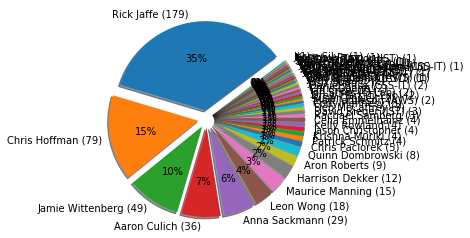

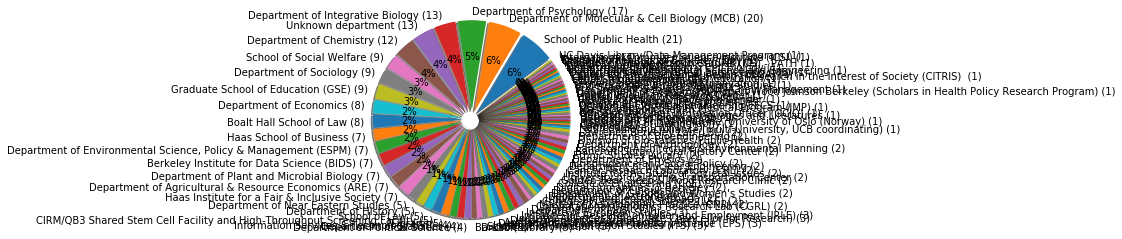

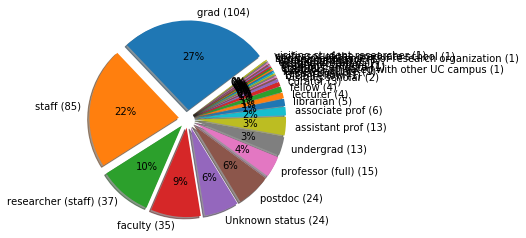

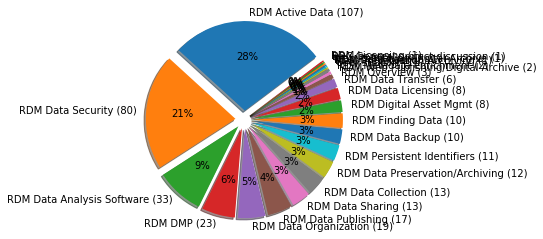

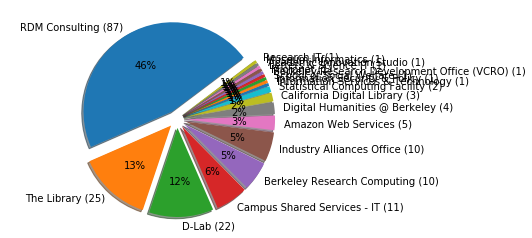

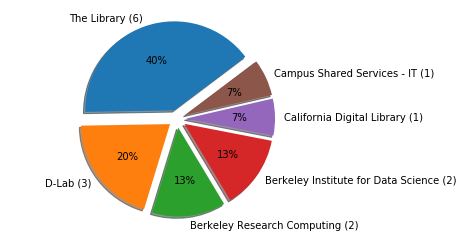

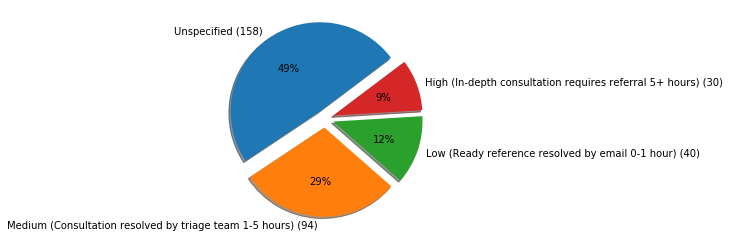

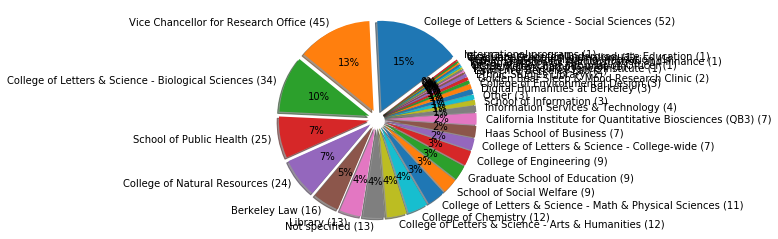

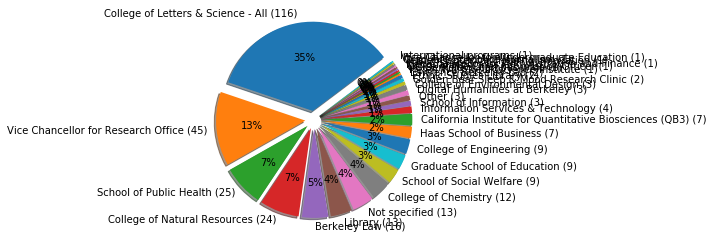

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

# Pie charts of each category, where the slices will be ordered and plotted counter-clockwise:

for s in srtdlsts:
    
    labels = []
    sizes = []
    labelsplusn = []
    
    for pair in s:
        labels.append(pair[0])
        sizes.append(pair[1])

    #print(labels) #debug
    #print(sizes)  #debug
    
    for label, size in zip(labels, sizes):
        labelplusn = str(label) + ' (' + str(size) + ')'
        labelsplusn.append(labelplusn)
    
    #print(labelsplusn)  #debug
    
    explode = [.1 for _ in range(len(s))]  # one value for each element in len(sortedlist)
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=37)  # originally labels=labels
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    #print('\n\n')

The next set of cells generate each pie chart separately so we can customize them. 

NOTE: These need to be customized based on the date range: the number of arguments in the statement 'explode = ()'
must be equal to the number of items in the sorted list, and that will vary depending upon the range of time covered by the reporting period.

ValueError: 'explode' must be of length 'x'

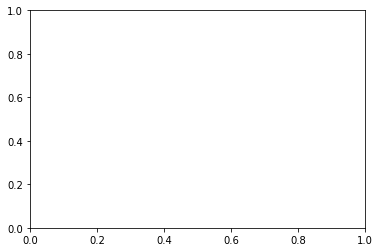

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt


# Pie chart of schools, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in spacount:
    labels.append(pair[0])
    sizes.append(pair[1])
#print(labels) #debug
#print(sizes)  #debug
#print(len(labels))

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug
    
explode = (.3, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .2, .2, .3, .4, .5,  .6, .7, .8, .9)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=37)  # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_spacount.png', bbox_inches='tight')

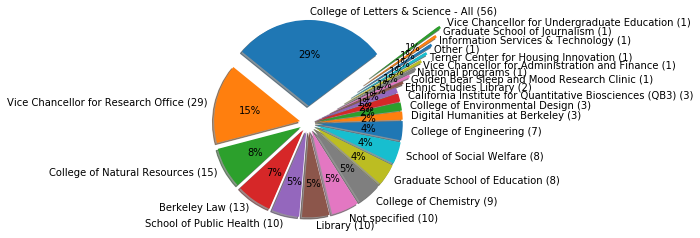

In [12]:
# Pie chart of schools with all L&S combined, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in slscount:
    labels.append(pair[0])
    sizes.append(pair[1])
#print(labels) #debug
#print(sizes)  #debug
#print(len(labels))

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.2, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .2, .3, .4, .5,  .6, .7, .8, .9)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=37)  #originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_slscount.png', bbox_inches='tight')

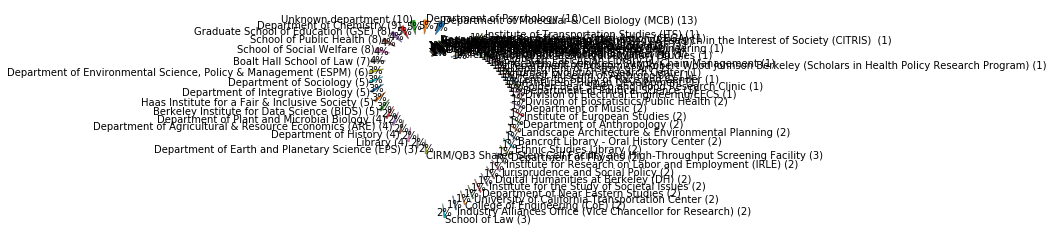

In [13]:
# Pie chart of original department/oru values, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in sdcount:
    labels.append(pair[0])
    sizes.append(pair[1])
#print(labels) #debug
#print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (2.1, 1.9, 1.9, 1.8, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.3, 4.7, 5.1, 5.5, 10.1, 9.7, 9.5, 9.3, 9.1, 8.9, 8.7, 8.5, 8.3, 8.1, 7.9, 7.7, 7.5, 7.3, 7.1, 6.9, 6.7, 6.5, 6.3, 6.1, 5.9, 5.7, 5.5, 5.3, 5.1, 4.9, 4.7, 4.5, 4.3, 4.1, 3.9, 2.1, 2.3,  2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7, .8, .8, .8, .9, .9, .9, .9, .9, .9, .9, .9, .9, .9, .9)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=50) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_sdcount.png', bbox_inches='tight')

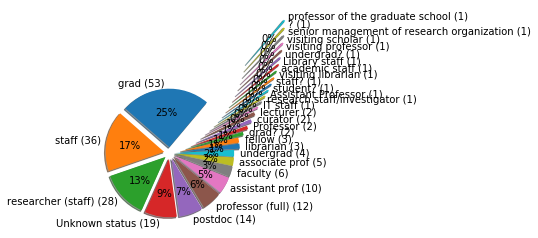

In [14]:
# Pie chart of position of client on campus, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in spcount:
    labels.append(pair[0])
    sizes.append(pair[1])
#print(labels) #debug
#print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .2, .2, .3, .4, .5, .6, .7, .8, .9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=50) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_spcount.png', bbox_inches='tight')

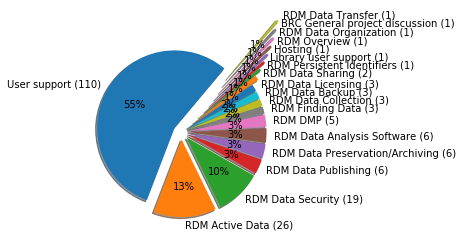

In [15]:
# Pie chart of (RDM Lifecycle) category, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in scacount:
    labels.append(pair[0])
    sizes.append(pair[1])
# print(labels) #debug
# print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .2, .3, .4, .5, .6, .7, .8, .9, )  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=50) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_scacount.png', bbox_inches='tight')

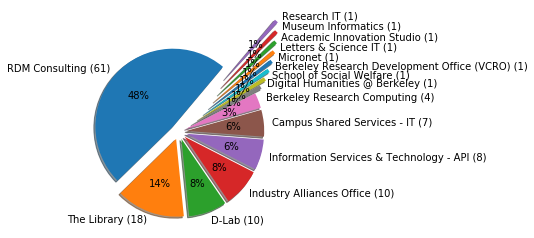

In [16]:
# Pie chart of sources (referrals in), where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in sscount:
    labels.append(pair[0])
    sizes.append(pair[1])
# print(labels) #debug
# print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.1, .1, .1, .1, .1, .1, .1, .2, .3, .4, .5, .6, .7, .8, .9)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=50) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_sscount.png', bbox_inches='tight')

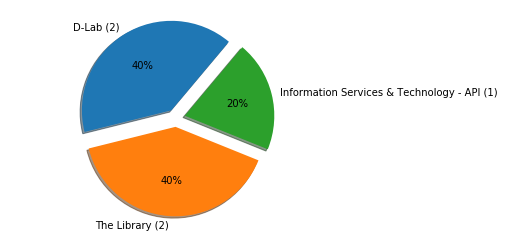

In [17]:
# Pie chart of referrals out, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in srcount:
    labels.append(pair[0])
    sizes.append(pair[1])
# print(labels) #debug
# print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.1, .1, .1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=50) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_srcount.png', bbox_inches='tight')

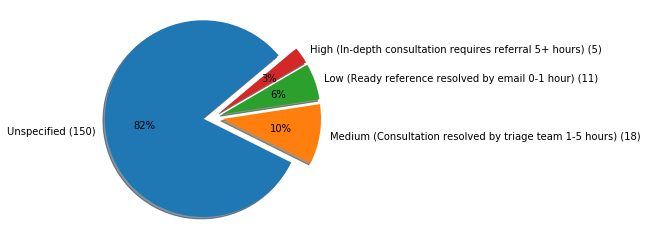

In [18]:
# Pie chart of complexity measures, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in scocount:
    labels.append(pair[0])
    sizes.append(pair[1])
#print(labels) #debug
#print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.1, .1, .1, .1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=40) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_scocount.png', bbox_inches='tight')

Print the top five values in each category (or all values, if less than five)

In [19]:
for lst, hdr in zip(srtdlsts, all_headings):
    print('\n' + 'Top Five: ' + hdr)
    for i in range(5):
        if i >= len(lst): continue
        (k,v) = lst[i]
        print(str(i+1) + '. ' + k + ': ' + str(v))
            
    


Top Five: Consultants, number of consults
1. Rick Jaffe: 108
2. Chris Hoffman: 44
3. Jamie Wittenberg: 28
4. Anna Sackmann: 21
5. Aaron Culich: 13

Top Five: Departments Served, number of engagements
1. Department of Molecular & Cell Biology (MCB): 13
2. Department of Psychology: 10
3. Unknown department: 10
4. Department of Chemistry: 9
5. Graduate School of Education (GSE): 8

Top Five: Patron Status, number of patrons
1. grad: 53
2. staff: 36
3. researcher (staff): 28
4. Unknown status: 19
5. postdoc: 14

Top Five: RDM Lifecycle Category
1. User support: 110
2. RDM Active Data: 26
3. RDM Data Security: 19
4. RDM Data Publishing: 6
5. RDM Data Preservation/Archiving: 6

Top Five: Referrals In
1. RDM Consulting: 61
2. The Library: 18
3. D-Lab: 10
4. Industry Alliances Office: 10
5. Information Services & Technology - API: 8

Top Five: Referrals Out
1. D-Lab: 2
2. The Library: 2
3. Information Services & Technology - API: 1

Top Five: Consultation Complexity
1. Unspecified: 150
2. Med